In [71]:
"""notebook for release qc metrics."""

import sys

sys.path.append("../../gentropy/src/")
release_path="../../otg_releases"
release_ver="2403"


In [72]:
from gentropy.common.session import Session
from pyspark.sql import functions as f
import matplotlib.pyplot as plt

session=Session()

variant_index_path = f"{release_path}/{release_ver}/variant_index"
variant_index=session.spark.read.parquet(variant_index_path, recursiveFileLookup=True)

# How many variants?
print("Variant index contains ", variant_index.select(f.col("variantId")).distinct().count(), " unique variants.")

# How many variants with MAF>=0.01 for EUR population?
#variant_index.filter(variant_index["alleleFrequencies.populationName"] > 0.05).show(10, False)

# How many variants that are presented in GnomAD LD for EUR (if possible, not sure)?


ConnectionRefusedError: [Errno 61] Connection refused

In [32]:
#v2g_path='gs://genetics_etl_python_playground/releases/24.03/variant_to_gene'
v2g_path=f"{release_path}/{release_ver}/variant_to_gene"
v2g=session.spark.read.parquet(v2g_path, recursiveFileLookup=True)

#How many variants?
print("Unique variants in v2g release: ", v2g.select(f.col("variantId")).distinct().count(), ", total variant to gene assignments: ", v2g.count(), ", number of v2g assignments where score > 0.8: ", v2g.filter(v2g["score"] > 0.8).count())
#v2g.select().toPandas().plot.hist()
#v2g.show()

Unique variants in v2g release:  329279 , total variant to gene assignments:  8190773 , number of v2g assignments where score > 0.8:  1747693


<Axes: ylabel='Frequency'>

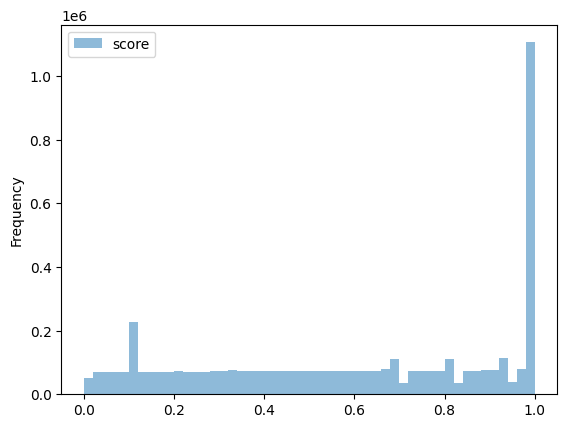

In [33]:
#The histogram/density plot for “score”

v2g.select(f.col("score")).toPandas().plot.hist(bins=10, alpha=0.5, label="v2g scores")

Number of unique finngen studies:  2408


Number of unique eQTLcat studies:  1801315


Number of unqiue eQTLcat tissues:  76
Number of unique gwascat studies:  79858
Number of unique SUMSTATS gwascat studies:  18435


<Axes: title={'center': 'Curated GWAScat sample size'}, ylabel='Frequency'>

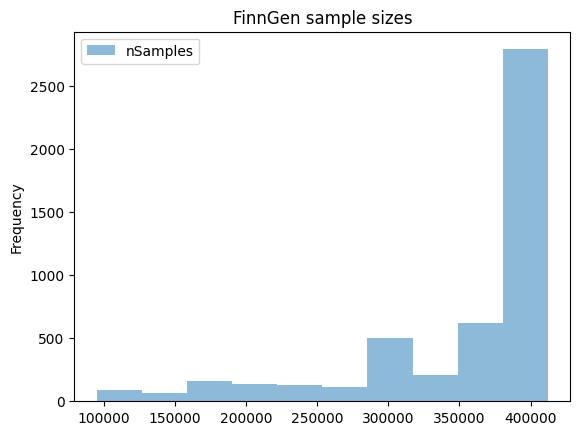

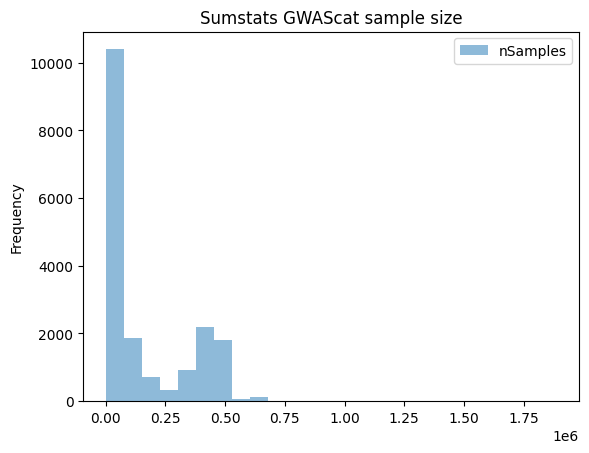

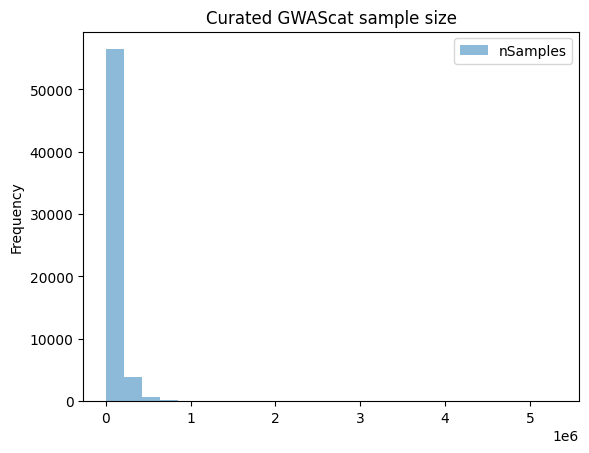

In [54]:
# study_index='gs://genetics_etl_python_playground/releases/24.03/study_index'
# Study Index. It has different files for different datasource (FinnGen, GWASCat, eQTLcat).
finngen_index_path=f"{release_path}/{release_ver}/study_index/finngen"
eqtl_index_path=f"{release_path}/{release_ver}/study_index/eqtl_catalog"
gwascat_path=f"{release_path}/{release_ver}/study_index/gwas_catalog"

# FinnGen:
finngen_index=session.spark.read.parquet(finngen_index_path, recursiveFileLookup=True)
# Number of studies.
print("Number of unique finngen studies: ", finngen_index.select(f.col("studyId")).distinct().count())
# The histogram/density plot for total sample size
finngen_index.select(f.col("nSamples")).toPandas().plot.hist(bins=10, alpha=0.5, label="FinnGen sample size", title="FinnGen sample sizes")
# eQTLcat:
# Number of studies
eqtl_index=session.spark.read.parquet(eqtl_index_path, recursiveFileLookup=True)
print("Number of unique eQTLcat studies: ", eqtl_index.select(f.col("studyId")).distinct().count())
# Number of tissues, list of tissues
print("Number of unqiue eQTLcat tissues: ", eqtl_index.select(f.col("tissueFromSourceId")).distinct().count())
#eqtl_index.select(f.col("tissueFromSourceId")).distinct().show(truncate=False)

# Gwas Catalog:
gwascat_index=session.spark.read.parquet(gwascat_path, recursiveFileLookup=True)
# Number of GWAS curated studies
print("Number of unique gwascat studies: ", gwascat_index.select(f.col("studyId")).distinct().count())
# Number of studies with full GWAS sumstats
print("Number of unique SUMSTATS gwascat studies: ", gwascat_index.filter(f.col("hasSumstats") == True).select(f.col("studyId")).distinct().count())
#gwascat_index
# The histogram/density plot for total sample size separately for curated studies and full GWAS
gwascat_index.filter(f.col("hasSumstats") == True).select(f.col("nSamples")).toPandas().plot.hist(bins=25, alpha=0.5, label="Sumstats GWAScat sample size", title="Sumstats GWAScat sample size")
gwascat_index.filter(f.col("hasSumstats") == False).select(f.col("nSamples")).toPandas().plot.hist(bins=25, alpha=0.5, label="Sumstats GWAScat sample size", title="Curated GWAScat sample size")
     

In [56]:
# Credible_set. Please use Daniels’ notebook as a reference. For each subfolder:
# finngen susie:
finngen_susie_path=f"{release_path}/{release_ver}/credible_set/finngen_susie"
# Number of CSs.
finngen_susie=session.spark.read.parquet(finngen_susie_path, recursiveFileLookup=True)
print("Number of unique finngen susie CSs: ", finngen_susie.select("studyId", "region", "credibleSetIndex").distinct().count())
# Number of unique studyids with at leas one CS.
print("Number of finngen studies with at least one CS: ", finngen_susie.select("studyId").distinct().count())
# The descriptive summary of 99% CS size and histogram/density plot
# Number of CSs with at leas one SNP with PIP>0.9
# Optional: the scatter plot of number of CSs per stydyid vs study sample size


+--------------------+--------------------+----------------+--------------------+----------------+----------+---------+----------+--------------+--------------+-------------------------------+-------------+-----------------+------------------+--------------------+
|             studyId|              region|credibleSetIndex|               locus|       variantId|chromosome| position|      beta|pValueMantissa|pValueExponent|effectAlleleFrequencyFromSource|standardError|finemappingMethod|credibleSetlog10BF|        studyLocusId|
+--------------------+--------------------+----------------+--------------------+----------------+----------+---------+----------+--------------+--------------+-------------------------------+-------------+-----------------+------------------+--------------------+
|FINNGEN_R10_AB1_A...|chrX:137681000-14...|               1|[{X_139181000_T_C...| X_139181000_T_C|         X|139181000|   2.86304|         4.813|            -8|                     2.22581E-4|      0.52455

In [60]:
finngen_susie.printSchema()

root
 |-- studyId: string (nullable = true)
 |-- region: string (nullable = true)
 |-- credibleSetIndex: integer (nullable = true)
 |-- locus: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- variantId: string (nullable = true)
 |    |    |-- posteriorProbability: double (nullable = true)
 |    |    |-- logBF: double (nullable = true)
 |    |    |-- pValueMantissa: float (nullable = true)
 |    |    |-- pValueExponent: integer (nullable = true)
 |    |    |-- beta: double (nullable = true)
 |    |    |-- standardError: double (nullable = true)
 |    |    |-- is95CredibleSet: boolean (nullable = true)
 |    |    |-- is99CredibleSet: boolean (nullable = true)
 |-- variantId: string (nullable = true)
 |-- chromosome: string (nullable = true)
 |-- position: integer (nullable = true)
 |-- beta: double (nullable = true)
 |-- pValueMantissa: float (nullable = true)
 |-- pValueExponent: integer (nullable = true)
 |-- effectAlleleFrequencyFromSource: float 

In [64]:
finngen_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").show()

+--------------------+--------------------+----------------+--------------------+
|             studyId|              region|credibleSetIndex|posteriorProbability|
+--------------------+--------------------+----------------+--------------------+
|FINNGEN_R10_AB1_A...|chrX:137681000-14...|               1|[0.44256864958122...|
|FINNGEN_R10_AB1_E...|chr8:8798515-1179...|               1|[0.10009301120518...|
|FINNGEN_R10_AD_LO...|chr1:206077223-20...|               1|[0.22706004801108...|
|FINNGEN_R10_ALCOP...|chr5:146309858-14...|               1|[0.06205840326852...|
|FINNGEN_R10_ALCOP...|chr7:141274035-14...|               2|[0.06115724611030...|
|FINNGEN_R10_ALLER...|chr10:7495529-104...|               2|[0.92556581715757...|
|FINNGEN_R10_APPEN...|chr4:109299841-11...|               1|[0.26530535214470...|
|FINNGEN_R10_ASTHM...|chr9:4709697-7709697|               1|[0.23258115219969...|
|FINNGEN_R10_ASTHM...|chr5:109592097-11...|               1|[0.21027385047731...|
|FINNGEN_R10_AST

In [67]:
finngen_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").groupBy("studyId", "region", "credibleSetIndex").agg(f.max("posteriorProbability").alias("maxPP")).show()


+--------------------+--------------------+----------------+--------------------+
|             studyId|              region|credibleSetIndex|               maxPP|
+--------------------+--------------------+----------------+--------------------+
|FINNGEN_R10_AB1_B...|chr1:158219533-16...|               2|[0.48889742131649...|
|FINNGEN_R10_AB1_B...|chr1:158219533-16...|               3|[0.04342541733120...|
|FINNGEN_R10_AB1_E...|chr5:126553152-12...|               1|[0.11154579323656...|
|FINNGEN_R10_AB1_M...|chr12:48442262-51...|               1| [0.998398336326089]|
|FINNGEN_R10_AB1_T...|chr12:29093487-32...|               1|[0.71032324537687...|
|FINNGEN_R10_AB1_V...|chr10:49118575-52...|               1|[0.94910227015121...|
|FINNGEN_R10_ABDOM...|chr2:109655479-11...|               2|[0.14555616217488...|
|FINNGEN_R10_ABDOM...|chr3:98156307-101...|               1|[0.93637051271650...|
|FINNGEN_R10_ABDOM...|chr6:132196143-13...|               1|[0.04935925369139...|
|FINNGEN_R10_ABD

In [69]:
from pyspark.sql import functions as F

# Explode the locus array
exploded_df = finngen_susie.select("*", F.explode("locus").alias("locus_element"))

# Extract the posteriorProbability values
exploded_df = exploded_df.withColumn("posteriorProbability", exploded_df.locus_element.posteriorProbability)

# Find the maximum posteriorProbability for each original row
max_posteriorProbability = exploded_df.groupBy(finngen_susie.columns).agg(F.max("posteriorProbability").alias("max_posteriorProbability"))

# Join the original DataFrame with the max_posteriorProbability DataFrame
finngen_susie = finngen_susie.join(max_posteriorProbability, on=finngen_susie.columns, how="left")

# Print the schema to verify the new column
finngen_susie.printSchema()

ConnectionRefusedError: [Errno 61] Connection refused

In [36]:
coloc_path='gs://genetics_etl_python_playground/releases/24.03/colocalisation'

In [ ]:
# Colocalisation. Not sure. But probably something like this:
# Number of coloclisation analyses of GWAS vs eQTLs
# Number of signals of colocalisation
# The average number of coloclisation signals per CS for each data/FM separately (GWAS curated pics, Finngen pics, Finngen susise, GWAS cat pics) -->

<!-- locus_to_gene_gold_standard.json
Number of variant-EFO pairs
Locus to gene model
Don’t know. Skip?
L2G prediction. Please use Daniels’ notebook as reference. For each datasource sepratly:
Histogram/density plot of l2g distribution.
Number of CS with at least one gene with L2G>=0.5
Number of CS with more than one gene with L2G>=0.5 -->

In [37]:
l2g_path='gs://genetics_etl_python_playground/releases/24.03/locus_to_gene_predictions'